In [ ]:
import torch
from google.colab import files
from IPython.display import Image
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd '/gdrive/My Drive/Colab Notebooks/YOLO'

/gdrive/My Drive/Colab Notebooks/YOLO


In [ ]:
!pip install -U -r yolov5/requirements.txt

In [ ]:
ls

 Cell_detection/              sperm_dataset_visem/
'lLHZ3eDgB8?key=G8ICS90lg8'   yolo_sperm_detection.ipynb
 runs/                        yolov5/
 sperm_dataset/               yolov5_cell_detection_SOP.ipynb
 sperm_dataset_old/


In [ ]:
import os
import cv2
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
!ls sperm_dataset

Data215  Data217  Data219  Data221    test   valid
Data216  Data218  Data220  data.yaml  train


# FUNCTIONS

In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



# Configuration and Data

In [ ]:
ls sperm_dataset

Data218/  data.yaml  test/


In [ ]:
mv 'sperm_dataset/valid (1)' 'sperm_dataset/valid'

In [ ]:
root = "sperm_dataset"
#file_type = ["train","valid","test"]
file_type = ["train","valid"]
folder_type = ["images", "labels"]
for f in file_type:
  print("*"*20)
  total_images = list(os.listdir(os.path.join(root,f,folder_type[0])))
  total_labels = list(os.listdir(os.path.join(root,f,folder_type[1])))
  print("total images in ", f , "is ", len(total_images), "total_labels is", len(total_labels))
  print("*"*20)


********************


FileNotFoundError: ignored

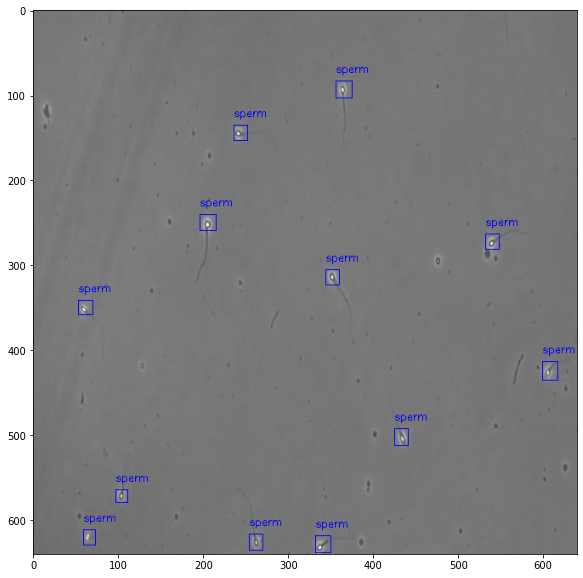

In [ ]:
classes = ["sperm"]
image_id = total_images[0]
label_id = total_images[0].replace(".jpg",".txt")
image_path = os.path.join(root,f,folder_type[0],image_id)

label_path = os.path.join(root,f,folder_type[1],label_id)
plt.figure(figsize=(10,10))
img = cv2.imread(image_path)
dh, dw, _ = img.shape

fl = open(label_path, 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    class_label, x, y, w, h = map(float, dt.split(' '))
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
    cv2.putText(img, classes[int(class_label)], (l, t-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
plt.imshow(img)
plt.show()

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
import yaml
with open("sperm_dataset/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'1'

In [ ]:
%%writetemplate sperm_dataset/data.yaml

train: ../sperm_dataset/train/images
val: ../sperm_dataset/valid/images

nc: 1
names: ['sperm']

In [ ]:
%cat sperm_dataset/data.yaml


train: ../sperm_dataset/train/images
val: ../sperm_dataset/valid/images

nc: 1
names: ['sperm']

In [ ]:
%cat yolov5/models/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]], 

In [ ]:
%%writetemplate yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Model Training

In [ ]:
# train yolov5s on Aquarium object detection data for 100 epochs [aroung 1000 epochs for better training and result]
# NOTE: All the images are already pre-processed to 416 x 416 size.
# We will be training for 100 epoch (increase it for better result) with batch size of 80
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5s.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance
%%time
%cd yolov5/
!python train.py --img 640 --batch 32 --epochs 1000 --data '../sperm_dataset/data.yaml' --cfg models/custom_yolov5l.yaml --weights ''

/gdrive/My Drive/Colab Notebooks/YOLO/yolov5
train: weights=, cfg=models/custom_yolov5l.yaml, data=../sperm_dataset/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=1000, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
YOLOv5 🚀 2021-10-8 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs

In [ ]:
ls runs/train/

exp7/


GROUND TRUTH TRAINING DATA:


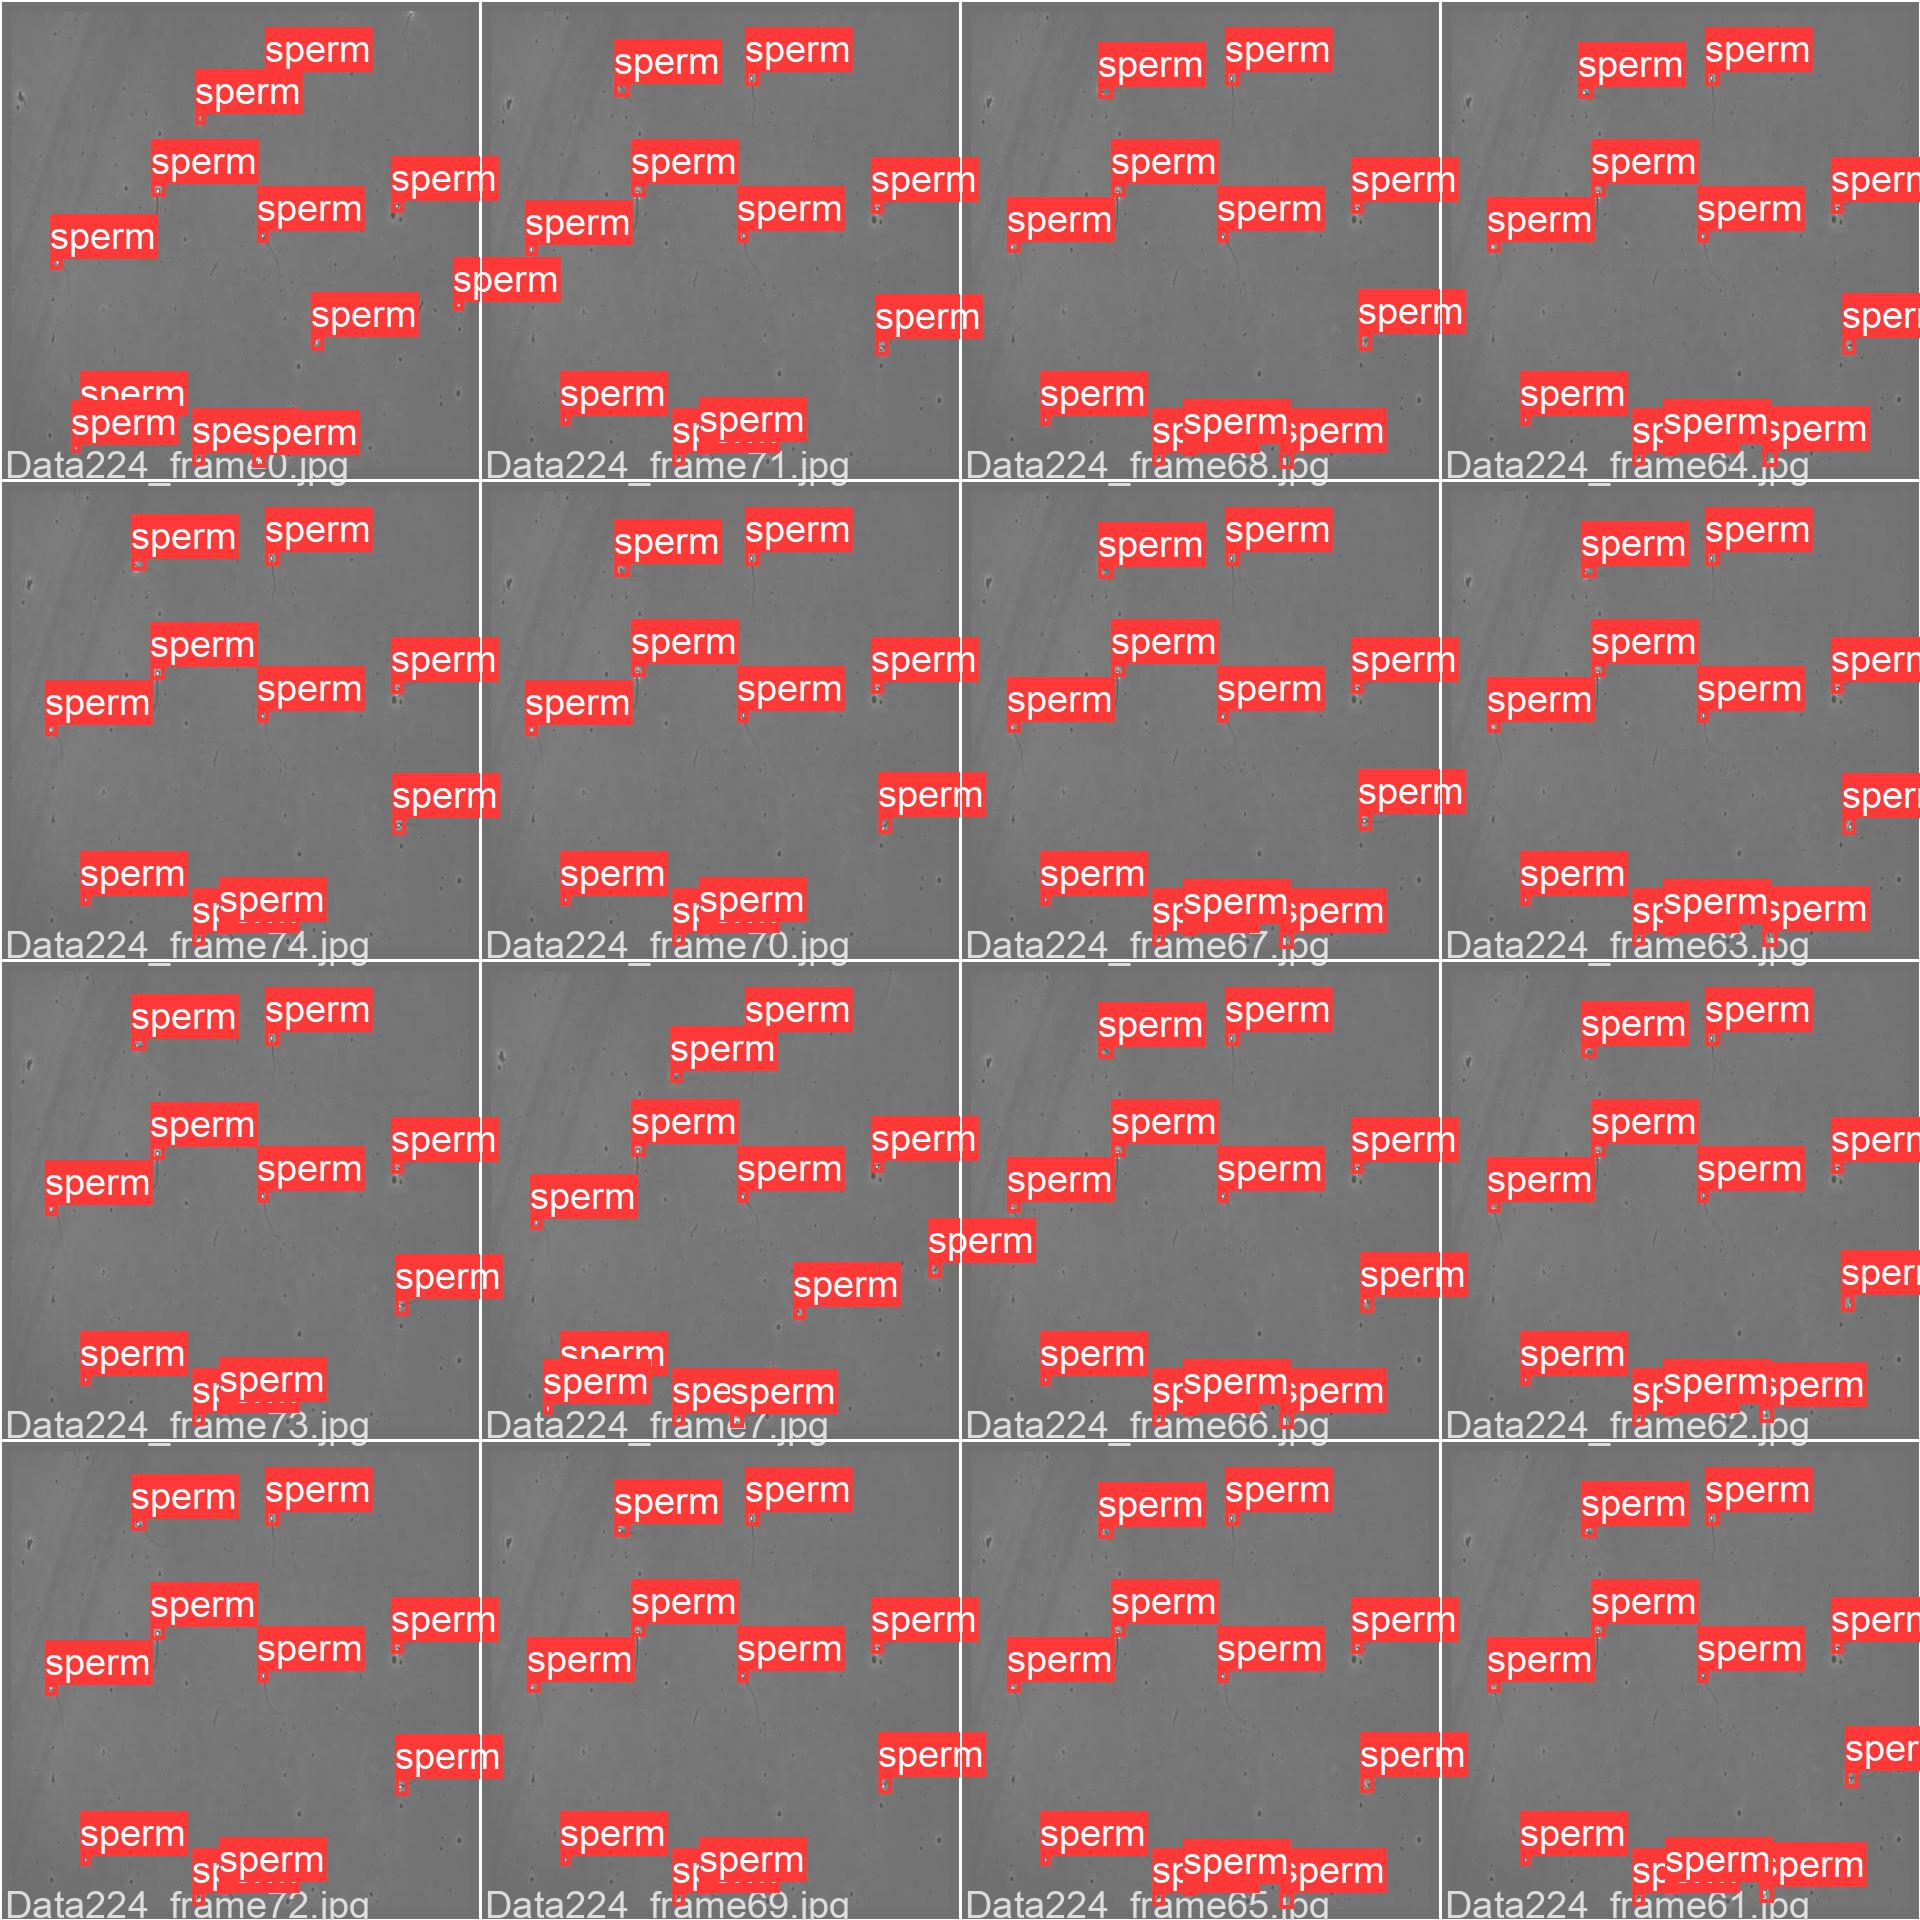

In [ ]:
# first, display our ground truth data
#%cd yolov5/
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/exp7/val_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


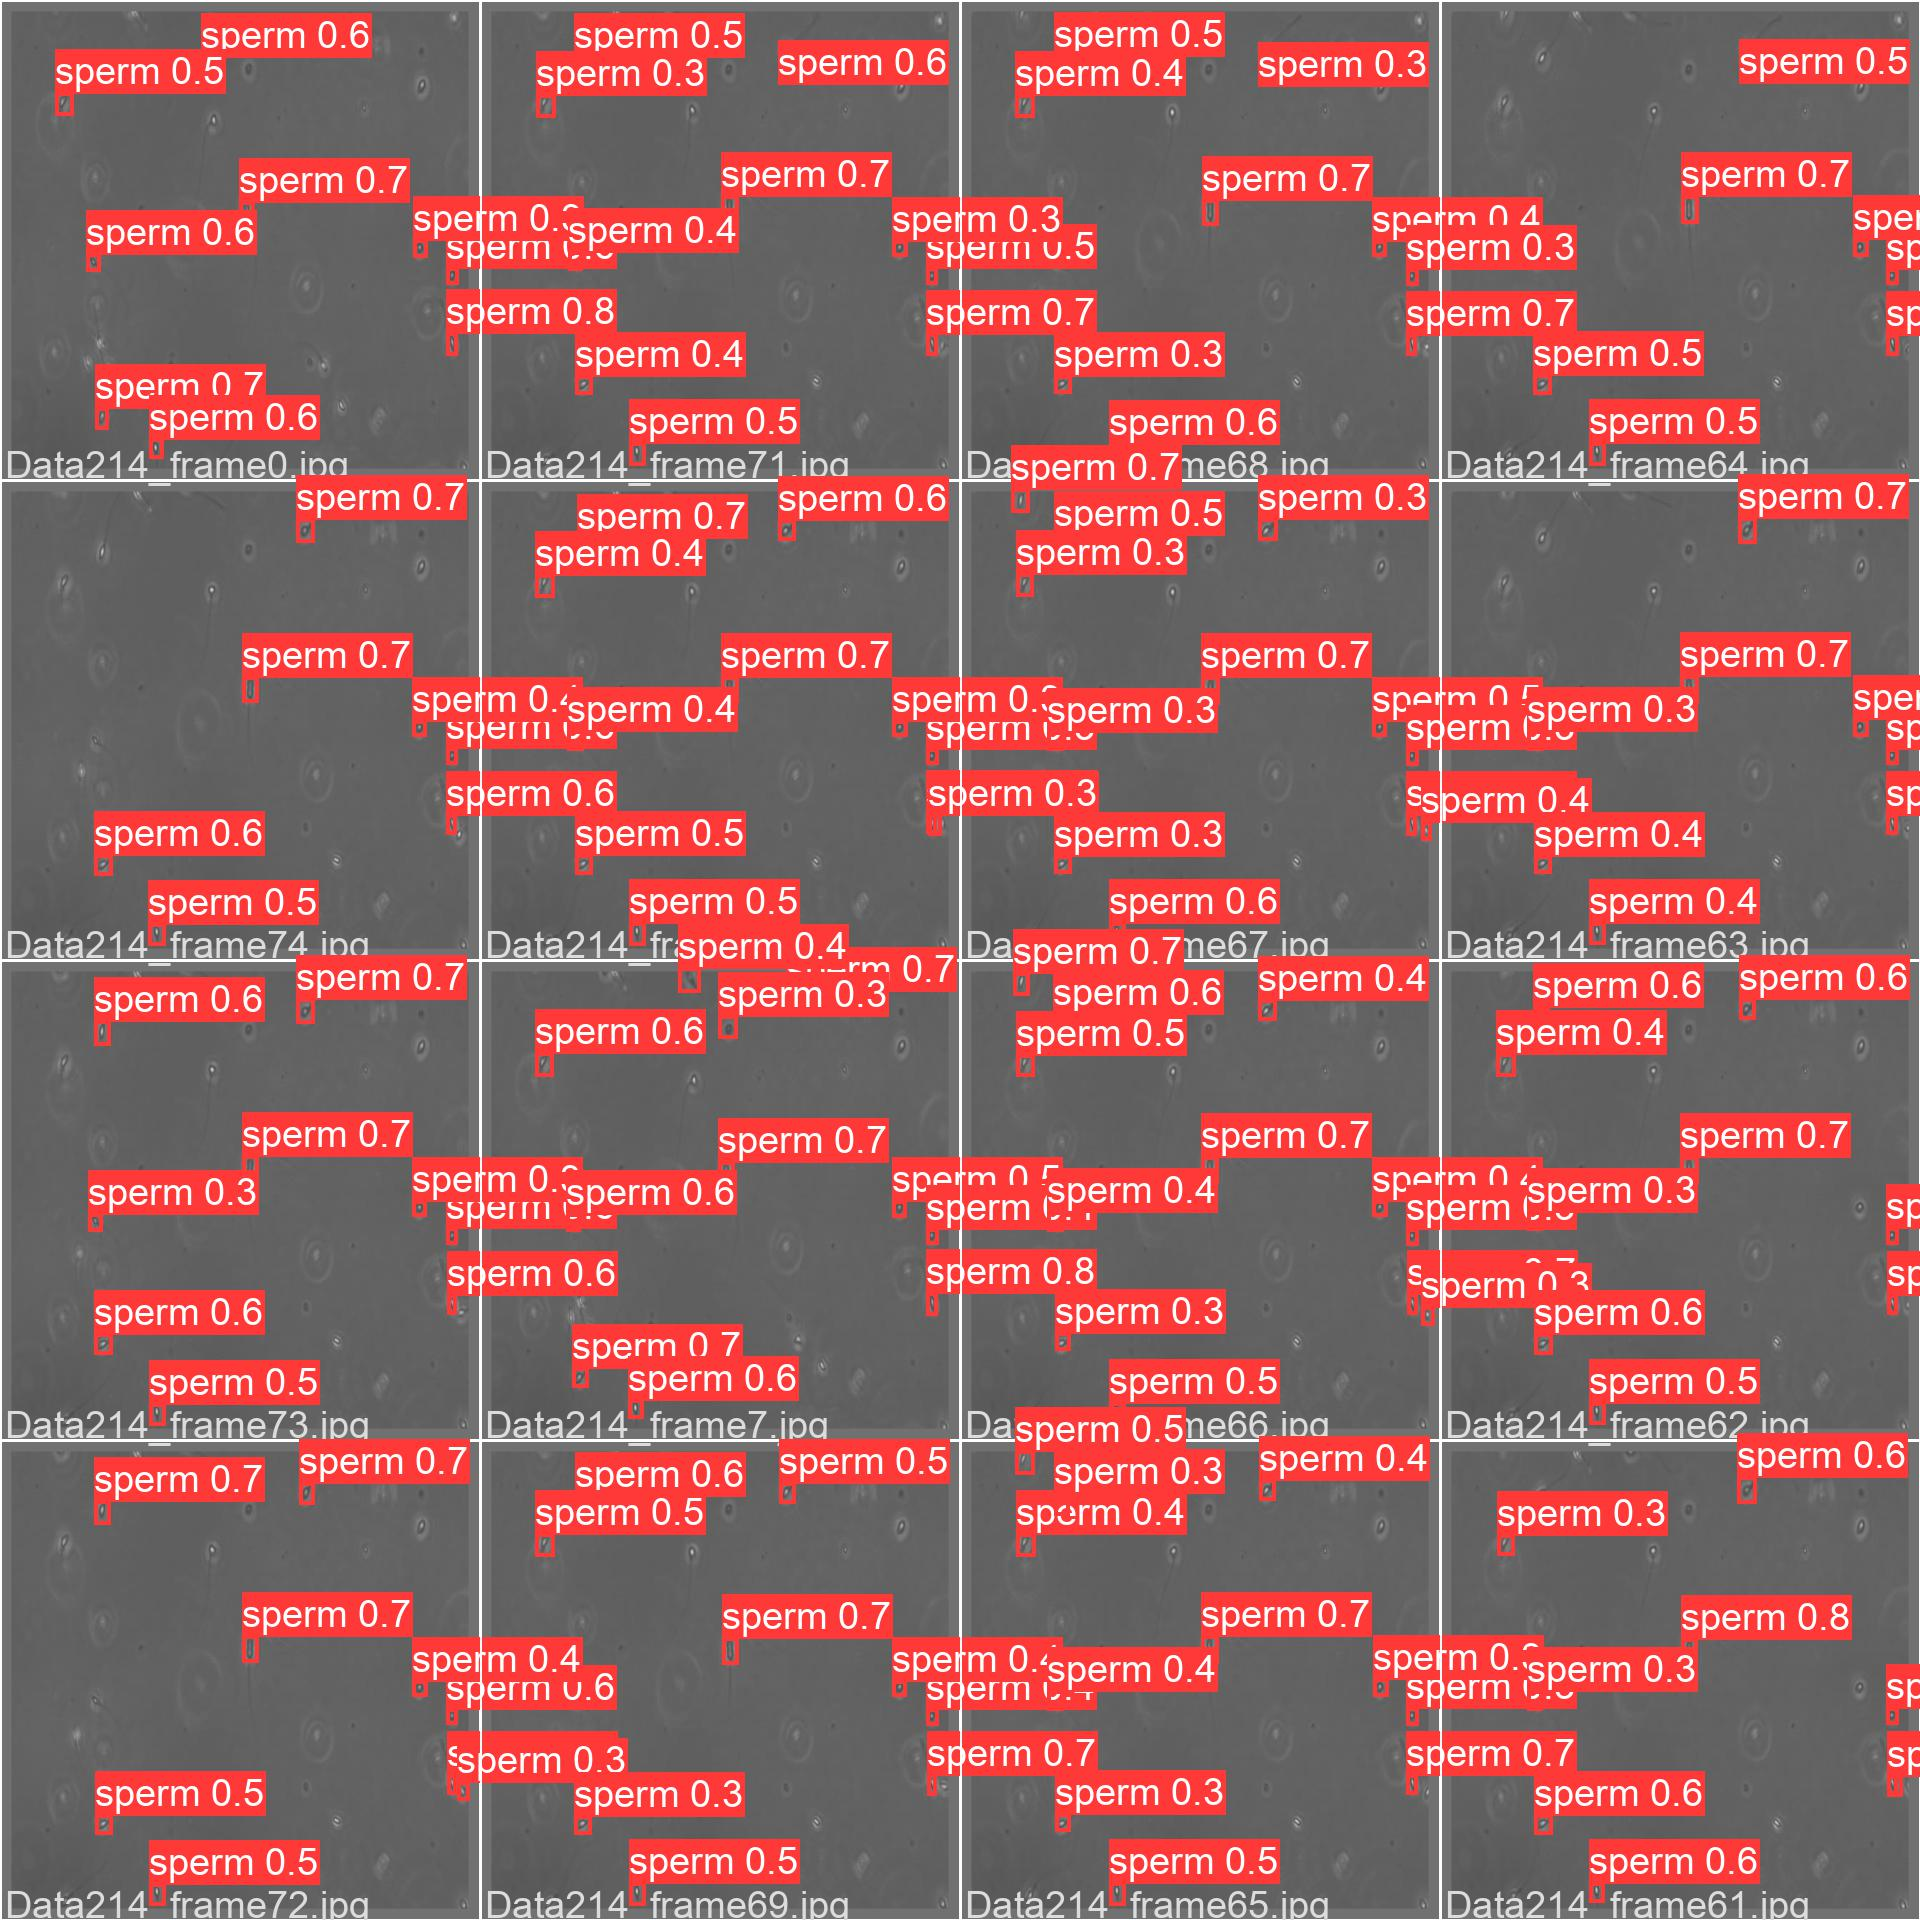

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/exp3/val_batch0_pred.jpg', width=900)

# Test the model

## Testing

In [ ]:
ls ../sperm_dataset/test/images/

In [ ]:
cd ..

/gdrive/My Drive/Colab Notebooks/YOLO/yolov5


In [ ]:
%cd yolov5/
!ls runs/train/exp7/weights/

/gdrive/My Drive/Colab Notebooks/YOLO/yolov5
best.pt  last.pt


In [ ]:
!python detect.py --weights runs/train/exp7/weights/best.pt --img 640 --conf 0.2 --source ../sperm_dataset/test/Data215 --hide-labels --line-thickness 1 --save-txt  --save-conf 

In [ ]:
 import glob
from IPython.display import Image, display

for imageName in glob.glob('runs/detect/exp4/*.jpg'): #assuming JPG
    print(imageName)
    display(Image(filename=imageName))
    print("\n")

total images in is  100 total_labels is 100
********************


In [ ]:
#exp 10 - 215 
#exp 11 - 216
#exp 12 - 217
#exp 13 - 218
#exp 14 - 219
#exp 15 - 220
#exp 16 - 221

In [ ]:
root = "runs/detect/exp11/"
#file_type = ["train","valid","test"]

folder_type = ["", "labels"]
total_images = list(os.listdir(os.path.join(root, folder_type[0])))
total_labels = list(os.listdir(os.path.join(root, folder_type[1])))
total_images.remove('labels')
print("total images in is ", len(total_images), "total_labels is", len(total_labels))
print("*"*20)

total_images.sort(key=natural_keys)
total_labels.sort(key=natural_keys)

total images in is  100 total_labels is 100
********************


In [ ]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in total_images:
    img = cv2.imread('runs/detect/exp11/' + filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('../sperm_detected_219.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Save labels in pandas dataframe

In [ ]:
root = "runs/detect/exp7/"
#file_type = ["train","valid","test"]

folder_type = ["", "labels"]
total_images = list(os.listdir(os.path.join(root, folder_type[0])))
total_labels = list(os.listdir(os.path.join(root, folder_type[1])))
total_images.remove('labels')
print("total images in is ", len(total_images), "total_labels is", len(total_labels))
print("*"*20)

total_images.sort(key=natural_keys)
total_labels.sort(key=natural_keys)

total images in is  100 total_labels is 100
********************


In [ ]:
total_images.sort(key=natural_keys)
total_labels.sort(key=natural_keys)

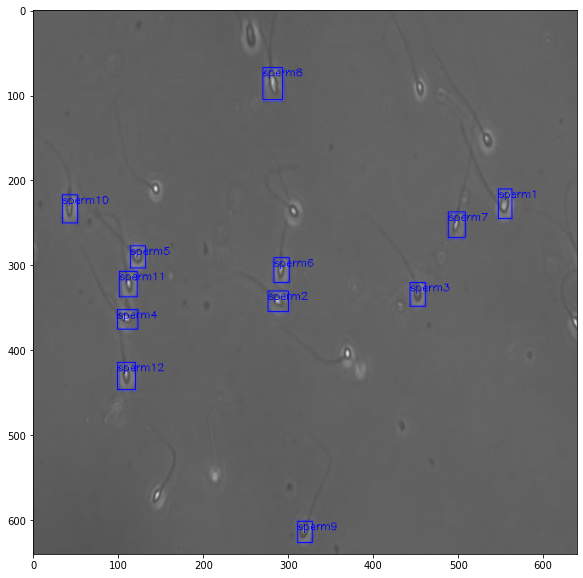

In [ ]:
classes = ["sperm"]
image_to_find = 0
image_id = total_images[image_to_find]
label_id = total_images[image_to_find].replace(".jpg",".txt")
image_path = os.path.join(root,folder_type[0],image_id)
label_path = os.path.join(root,folder_type[1],label_id)
plt.figure(figsize=(10,10))
img = cv2.imread(image_path)
dh, dw, _ = img.shape

fl = open(label_path, 'r')
data = fl.readlines()
fl.close()
count = 0
for dt in data:
    count+=1
    # Split string to float
    class_label, x, y, w, h, conf = map(float, dt.split(' '))
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
    cv2.putText(img, classes[int(class_label)]+str(count), (l, t+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
plt.imshow(img)
plt.show()

In [ ]:
classes = ["sperm"]
image_to_find = 1
image_id = total_images[image_to_find]
label_id = total_images[image_to_find].replace(".jpg",".txt")
image_path = os.path.join(root,folder_type[0],image_id)
label_path = os.path.join(root,folder_type[1],label_id)
plt.figure(figsize=(10,10))
img = cv2.imread(image_path)
dh, dw, _ = img.shape

fl = open(label_path, 'r')
data = fl.readlines()
fl.close()
count = 0
for dt in data:
    count+=1
    # Split string to float
    class_label, x, y, w, h, conf = map(float, dt.split(' '))
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
    cv2.putText(img, classes[int(class_label)]+str(count), (l, t+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
plt.imshow(img)
plt.show()

NameError: ignored

In [ ]:
total_images[0]

'Data211_frame0.jpg'

In [ ]:
## saving all of them in a dictionary
classes = ["sperm"]
results = {}
for i in range(len(total_images)):
  #print(i)
  image_id = total_images[i]
  label_id = total_images[i].replace(".jpg",".txt")
  image_path = os.path.join(root,folder_type[0],image_id)
  label_path = os.path.join(root,folder_type[1],label_id)
  results[image_path] = []
  fl = open(label_path, 'r')
  data = fl.readlines()
  fl.close()

  for dt in data:
      # Split string to float
      class_label, x, y, w, h, conf = map(float, dt.split(' '))
      cordinates = [x,y]
      results[image_path].append(cordinates)


In [ ]:
images = list(results.keys())

In [ ]:
def distance_between_center(x1,y1,x2,y2):
  return ((((x2 - x1 )**2) + ((y2-y1)**2) )**0.5)

In [ ]:
index_to_find = 0
image1_data = results[images[44]]
image2_data = results[images[45]]
x1 = image2_data[index_to_find][0]
y1 = image2_data[index_to_find][1]
max = 100.00
index = 0
count = 0
for x,y in image1_data:
  distance = distance_between_center(x1,y1,x,y)
  print(distance)
  if(distance<=max):
    max = distance
    index = count
  count+=1

0.43194011810087757
0.0011052081251963226
0.4413779690061569
0.022669457360069308
0.11676417038201399
0.2640023970061635
0.3015622538863244
0.25157851773551737
0.3798358812434654
0.2973199648930424
0.27926031727583495
0.46901936739648614
0.3338508853844782
0.016480190532879135
0.3330913995722495
0.4111538554031081


In [ ]:
index = 1
i = 0
print(i, index)
image1_data = results[images[0]]
Total_distance = 0
for i in range(1, len(images)):
  
  image2_data = results[images[i]]
  x1 = image1_data[index][0]
  y1 = image1_data[index][1]

  max = 100.00
  index = 0
  count = 0
  for x,y in image2_data:
    distance = distance_between_center(x1,y1,x,y)
    if(distance<=max):
      max = distance
      index = count
    count+=1
  if(max>=0.05):
      print(sperm_index, i)
      break
  elif(max<0.05):
    Total_distance+=max
  print(i, index, image2_data[index], max)
  image1_data = results[images[i]]

0 1
1 2 [0.449219, 0.540625] 0.005240896201986873
2 2 [0.447656, 0.538281] 0.002817322310279745
3 0 [0.447656, 0.536719] 0.0015620000000000633
4 1 [0.449219, 0.535156] 0.002210415797989121
5 4 [0.45, 0.53125] 0.003983314825619458
6 5 [0.453125, 0.529688] 0.0034936326366691423
7 4 [0.455469, 0.528125] 0.0028173223102798068
8 5 [0.454688, 0.532031] 0.0039833148256195675
9 4 [0.453125, 0.534375] 0.002817322310279745
10 3 [0.45, 0.5375] 0.004419417382415867
11 4 [0.448438, 0.535937] 0.0022097088043450354
12 4 [0.450781, 0.532812] 0.003905800046085335
13 6 [0.455469, 0.528125] 0.0066291261113362605
14 8 [0.45625, 0.524219] 0.003983314825619448
15 5 [0.455469, 0.526563] 0.0024706875561268412
16 6 [0.453125, 0.53125] 0.005240448931150845
17 6 [0.452344, 0.532031] 0.0011045007922133928
18 7 [0.453125, 0.53125] 0.0011045007922133928
19 8 [0.454688, 0.528125] 0.003494079850261041
20 8 [0.454688, 0.525781] 0.0023439999999999017
21 9 [0.455469, 0.522656] 0.0032211156452385137
22 8 [0.453906, 0.525

In [ ]:
Total_distance

0.24029754336040496

In [ ]:
distance = Total_distance*0.45 #= 0.324 mm
print(distance)
print(distance/(99/30)) #0.1mm/second = 100micro-meter/second
#0.1*60 = 6mm/ minute

0.10813389451218224
0.032767846821873406


In [ ]:
vcl = Total_distance*

In [ ]:
0.150361 

In [ ]:
final_all_distance = []
for sperm_index in range(len(results[images[0]])):
  index = sperm_index
  i = 0
  #print(i, index)
  image1_data = results[images[0]]
  Total_distance = 0
  for i in range(1, len(images)):
    
    image2_data = results[images[i]]
    x1 = image1_data[index][0]
    y1 = image1_data[index][1]

    max = 100.00
    index = 0
    count = 0
    flag = 0
    for x,y in image2_data:
      distance = distance_between_center(x1,y1,x,y)
      
      if(distance<=max):
        max = distance
        index = count
      count+=1

    if(max>=0.05):
      print(sperm_index, i)
      break
    elif(max<0.05):
      Total_distance+=max
    
    #print(i, index, image2_data[index])
    image1_data = results[images[i]]
  final_all_distance.append(Total_distance)

0 3
3 77


In [ ]:
final_all_distance

[0.0,
 0.24029754336040496,
 0.06192515920758417,
 0.06544950280463697,
 0.12208313686434748,
 0.0807848127714562,
 0.13763099987567048,
 0.18823385064345827,
 0.06835528983556063,
 0.06629630586381774,
 0.059754011130284765,
 0.06719865973904601]

In [ ]:
0.72*0.45(each pixel distance) = 0.324 mm
0.324/(97/30) = 0.1mm/second
0.1*60 = 6mm/ minute

0.10020618556701032

In [1]:
import random

print(random.randint(0,9))


6


In [ ]:
distance of the Curvlinear path = 0.324mm
Velocity = 0.1mm/second or .36meters per hour or 6mm per minute

In [ ]:
sperm_dict = {}
image1_data = results[images[0]]
for sperm_count in range(len(image1_data)):
  sperm_dict[sperm_count] = [image1_data[sperm_count]]


for i in range(1, len(images)):
  image1_data = [item[-1] for item in list(sperm_dict.values())]
  image2_data = results[images[i]]
  count_image1 = 0
  for x1,y1 in image1_data:
    max = 100.00
    index = 0
    count_image2 = 0
    for x,y in image2_data:
      distance = distance_between_center(x1,y1,x,y)
      if(distance<=max):
        max = distance
        index = count_image2
      count_image2+=1
    if(max>=0.05):
      print("new sperm detected")
      sperm_count +=1
      sperm_dict[sperm_count]= [image1_data[count_image1]]
    else:
      sperm_dict[count_image1].append(image2_data[index])
    #print(max, index)
    count_image1+=1

Initial queue
deque(['a', 'b', 'c'])

Elements dequeued from the queue
a
b
c

Queue after removing elements
deque([])


In [ ]:
sperm_dict

In [ ]:
len(sperm_dict[10])

34